In [26]:
import pandas as pd
df = pd.read_csv("Bengaluru_House_Data.csv")

In [27]:

print ("The shape of the dataset is " ,df.shape) 
print ("All the columns in the dataset are respectively---")
print (df.columns)


The shape of the dataset is  (13320, 9)
All the columns in the dataset are respectively---
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [28]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print ("Total no of missing values in each features before cleaning")
print (missing_values)

Total no of missing values in each features before cleaning
society         5502
balcony          609
bath              73
size              16
location           1
area_type          0
availability       0
total_sqft         0
price              0
dtype: int64


In [29]:
df = df.dropna(subset="location")
df = df.dropna(subset="size")
df = df.dropna(subset="bath")
df["society"] = df["society"].fillna("not provided")

### 🛠️ Feature Engineering: Balcony from BHK

To handle missing balcony data, we estimated balcony count based on BHK:

- 1–2 BHK → 1 balcony  
- 3–4 BHK → 2 balconies  
- 5+ BHK → 3 balconies  

🔍 This added consistency and helped the model capture structural patterns better.


In [30]:
df["bhk"] = df["size"].apply(lambda x : x.split(" ")[0])
balcony_by_bhk = df.groupby("bhk")["balcony"].median()

def balcony_filler(a):
    if pd.isna(a["balcony"]):
        return balcony_by_bhk.get(a["bhk"])
    else:
        return a["balcony"]

df["balcony"] = df.apply(balcony_filler , axis= 1)
df = df.dropna(subset="balcony")

In [31]:
def conversion(a):
    try:
        return float(a)   
    except:
        try:
            if "-" in a:
                parts = a.split("-")
                if len(parts)==2:
                  return (float(parts[0]) + float(parts[1])) / 2

        except:
            return None
            
    return None

df["total_sqft_cleaned"] = df["total_sqft"].apply(conversion)
df = df.dropna(subset = "total_sqft_cleaned")

In [32]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print ("Total no of missing values in each features before cleaning")
print (missing_values)


Total no of missing values in each features before cleaning
area_type             0
availability          0
location              0
size                  0
society               0
total_sqft            0
bath                  0
balcony               0
price                 0
bhk                   0
total_sqft_cleaned    0
dtype: int64


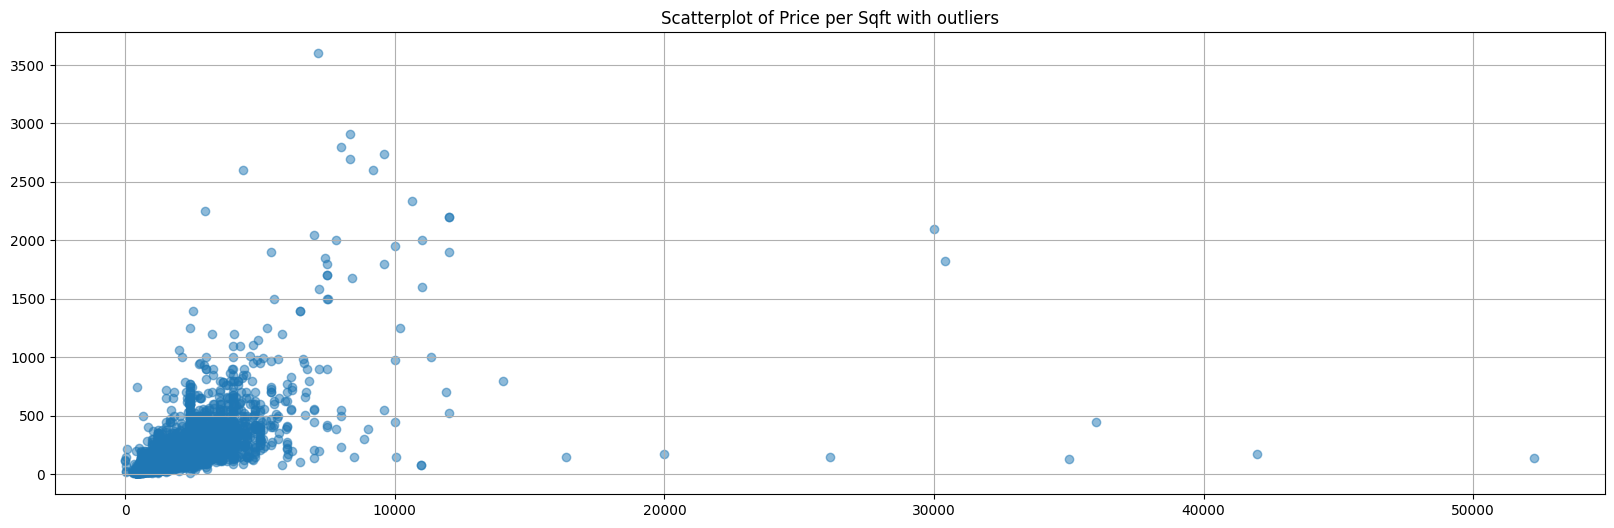

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))  
plt.scatter(df["total_sqft_cleaned"] , df["price"] , alpha=0.5)
plt.title("Scatterplot of Price per Sqft with outliers")
plt.grid(True)
plt.show()    


### 📊 Outlier Removal Using IQR Method

To ensure a clean and reliable dataset, we used the **Interquartile Range (IQR) method** to detect and remove outliers. 

- **IQR = Q3 - Q1**: It measures the middle 50% spread of the data.
- Any data point outside **[Q1 - 1.5×IQR, Q3 + 1.5×IQR]** is considered an outlier.

🔍 **Why IQR?**  
IQR is robust to extreme values and does not assume any data distribution. This helps in reducing noise and improving model performance.


In [34]:
q1_sqft = df["total_sqft_cleaned"].quantile(0.25)
q3_sqft = df["total_sqft_cleaned"].quantile(0.75)

iqr_sqft = q3_sqft - q1_sqft

q1_price = df["price"].quantile(0.25)
q3_price = df["price"].quantile(0.75)

iqr_price = q3_price - q1_price

lower_sqft  = q1_sqft - 1.5*iqr_sqft
upper_sqft  = q3_sqft + 1.5*iqr_sqft

lower_price = q1_price - 1.5 * iqr_sqft
upper_price = q3_price + 1.5 * iqr_price
        
df_cleaned = df[  
                (df["total_sqft_cleaned"] >= lower_sqft) & 
                (df["total_sqft_cleaned"] <= upper_sqft) &
                (df["price"] >= lower_price) & 
                (df["price"] <= upper_price)
                ]

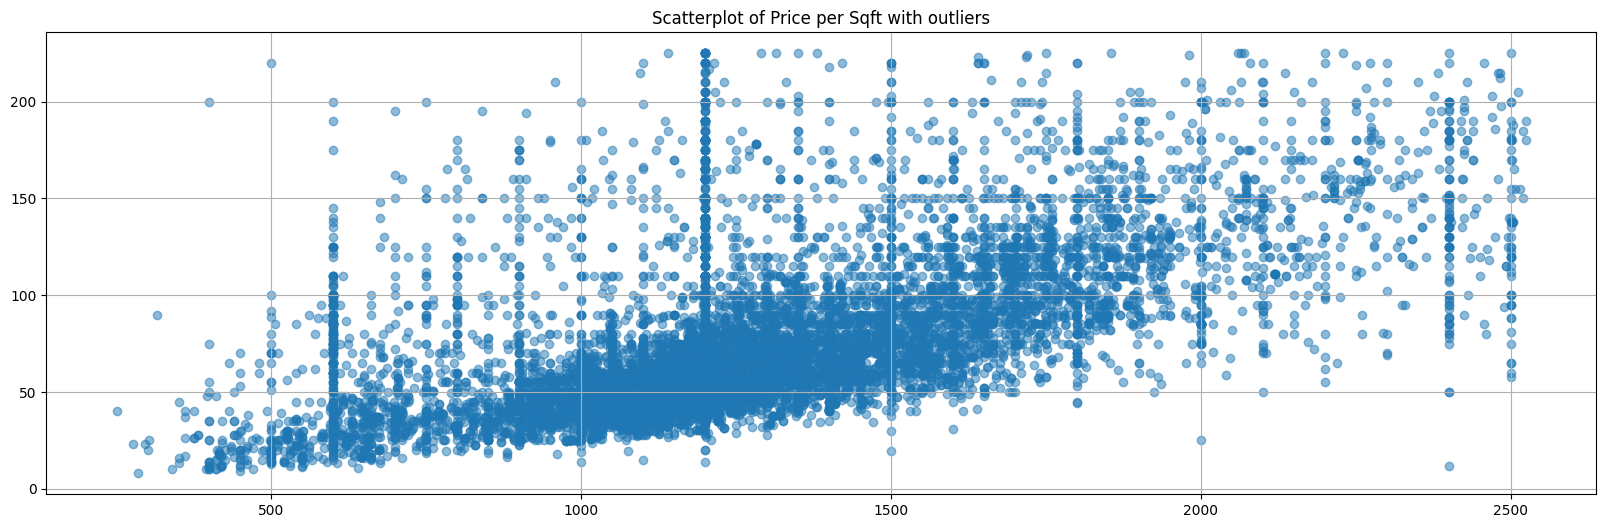

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))  
plt.scatter(df_cleaned["total_sqft_cleaned"] , df_cleaned["price"] , alpha=0.5)
plt.title("Scatterplot of Price per Sqft with outliers")
plt.grid(True)
plt.show()    


### 🏙️ EDA on Bengaluru Housing Data

The following Exploratory Data Analysis (EDA) uncovers key insights into the Bengaluru housing market. It focuses on understanding the relationship between **location**, **price**, **area**, and **type of property** — helping us identify patterns, outliers, and trends that influence house pricing in the city.


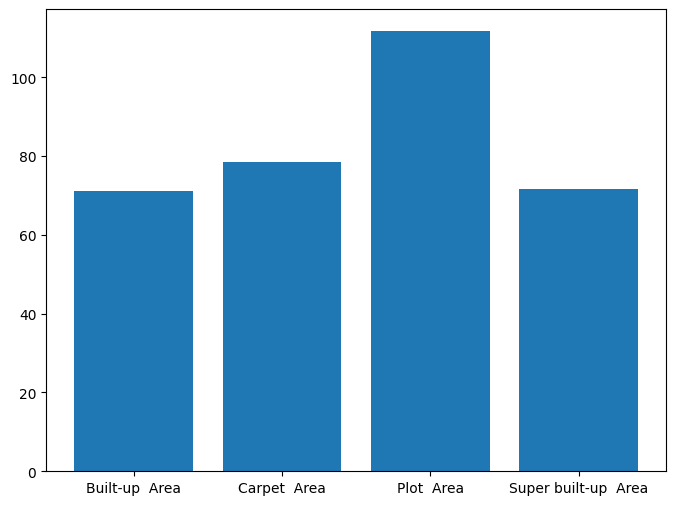

area_type
Built-up  Area           71.014163
Carpet  Area             78.483812
Plot  Area              111.677240
Super built-up  Area     71.578424
Name: price, dtype: float64


In [63]:
a = df_cleaned.groupby("area_type")["price"].mean()
plt.figure(figsize=(8, 6))
plt.bar( a.index , a.values)
plt.show()
print (a)

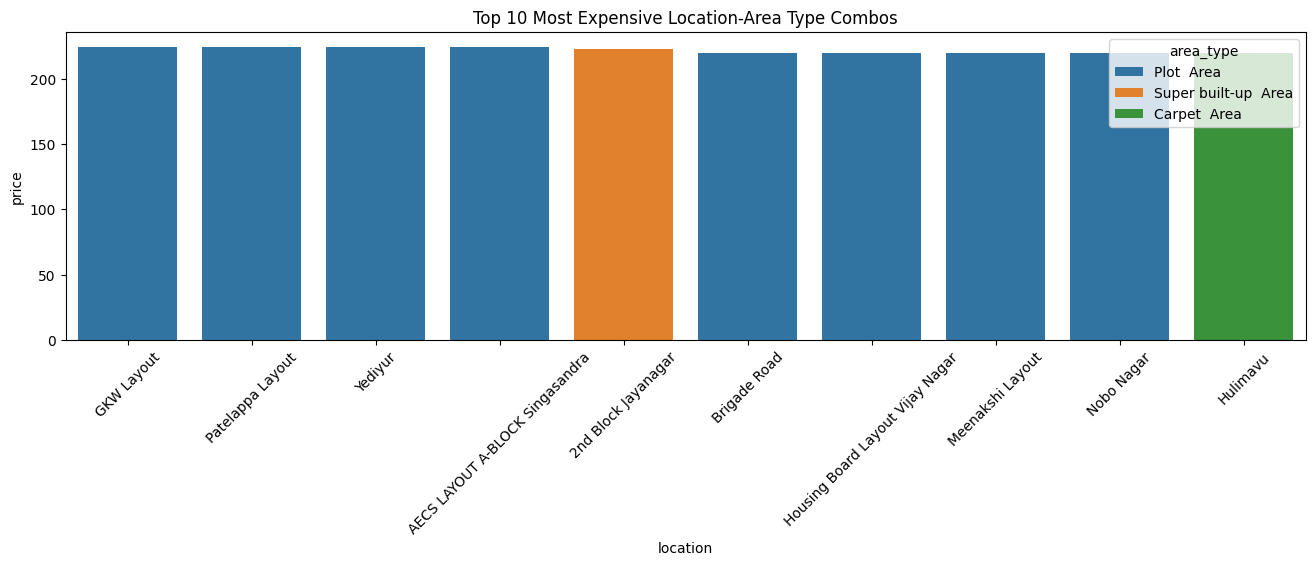

location                          area_type           
GKW Layout                        Plot  Area              225.0
Patelappa Layout                  Plot  Area              225.0
Yediyur                           Plot  Area              225.0
AECS LAYOUT A-BLOCK Singasandra   Plot  Area              225.0
2nd Block Jayanagar               Super built-up  Area    223.0
Brigade Road                      Plot  Area              220.0
Housing Board Layout Vijay Nagar  Plot  Area              220.0
Meenakshi Layout                  Plot  Area              220.0
Nobo Nagar                        Plot  Area              220.0
Hulimavu                          Carpet  Area            220.0
Name: price, dtype: float64


In [65]:
locating_wise_price = df_cleaned.groupby(["location" , "area_type"])["price"].mean()
a = locating_wise_price.sort_values(ascending=False).head(10)
import seaborn as sns

top10_df = a.reset_index()
top10_df.columns = ['location', 'area_type', 'price']

plt.figure(figsize=(16, 4))
sns.barplot(data=top10_df, x='location', y='price', hue='area_type')
plt.title("Top 10 Most Expensive Location-Area Type Combos")
plt.xticks(rotation=45)
plt.show()
print (a)


location
Kalhalli                                    2400.0
Bileshivale                                 2400.0
Bharath Housing Society Layout              2400.0
Viswapriyanagar.begur Road.bommanahalli.    2400.0
Annapurneshwari Nagar                       2400.0
Anekal - Hosur Road                         2400.0
Vayunandana Layout                          2400.0
Escorts Colony                              2400.0
Bande Nallasandra                           2400.0
Deepanjali Nagar                            2320.0
Name: total_sqft_cleaned, dtype: float64


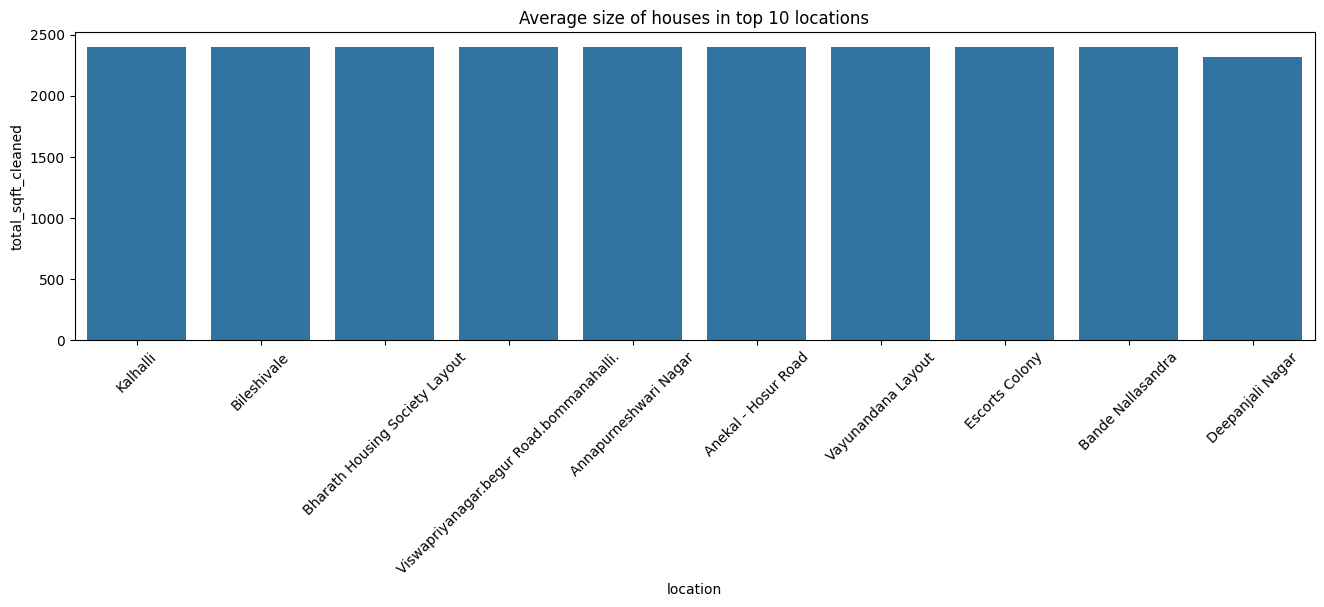

In [66]:
locating_wise_size = df_cleaned.groupby(["location"])["total_sqft_cleaned"].mean()
a = locating_wise_size.sort_values(ascending=False).head(10)
print (a)
import seaborn as sns

top10_df = a.reset_index()
top10_df.columns = ['location', 'total_sqft_cleaned']

plt.figure(figsize=(16, 4))
sns.barplot(data=top10_df, x='location', y='total_sqft_cleaned')
plt.title("Average size of houses in top 10 locations")
plt.xticks(rotation=45)
plt.show()


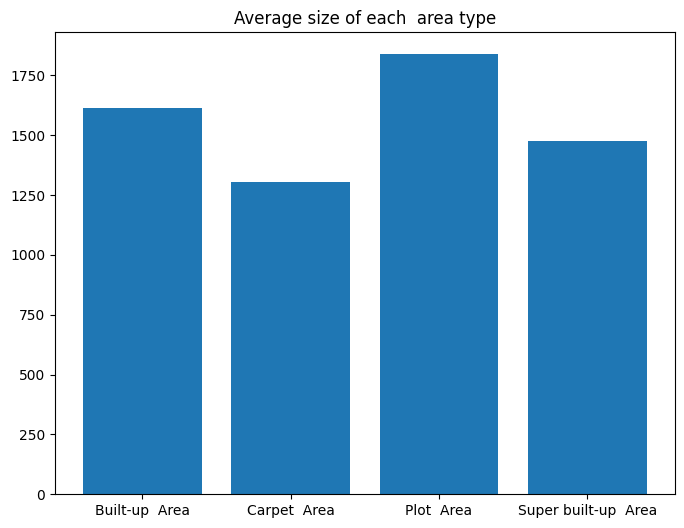

area_type
Built-up  Area          1614.363960
Carpet  Area            1305.074012
Plot  Area              1838.320146
Super built-up  Area    1476.053164
Name: total_sqft_cleaned, dtype: float64


In [39]:
a = (df.groupby("area_type")["total_sqft_cleaned"].mean())
plt.figure(figsize=(8, 6))
plt.title("Average size of each  area type")
plt.bar( a.index , a.values)
plt.show()
print (a)

In [40]:
print (df_cleaned.columns)
X = df_cleaned[["location" , "bhk" , "total_sqft_cleaned" , "balcony" , "area_type" , "bath"]]
y = df_cleaned[["price"]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price', 'bhk', 'total_sqft_cleaned'],
      dtype='object')


In [41]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=["location" , "area_type"])

X_train_encoded = encoder.fit_transform(X_train , y_train)
X_test_encoded = encoder.transform(X_test)


### 🎯 Target Encoding Explanation

We transformed location and area type into numerical values based on how they influence house prices. Instead of creating many columns, we replaced each category with the average price of houses in that category. This made the data simpler and more meaningful for the model, helping it make better predictions.


In [45]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


model1 = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
model2 = LinearRegression()
model3 = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42)
model4 = SVR(kernel='rbf', C=100, gamma=0.01)

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
results = []

models = {
    "Random Forest": model1,
    "Linear Regression": model2,
    "Gradient Boosting": model3,
    "Support Vector Regressor": model4
}

for name, model in models.items():
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": round(mae, 2),
        "R² Score": round(r2, 2)
    })

results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
print("\n Model Performance Summary:\n")
print(results_df.to_string(index=False))



c:\Users\pranj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pranj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\pranj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Model Performance Summary:

                   Model   MAE  R² Score
           Random Forest 15.07      0.71
       Gradient Boosting 15.14      0.71
       Linear Regression 17.72      0.64
Support Vector Regressor 16.37      0.63


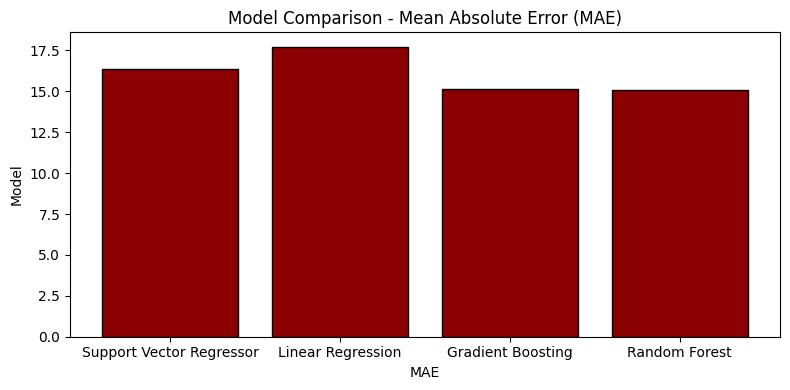

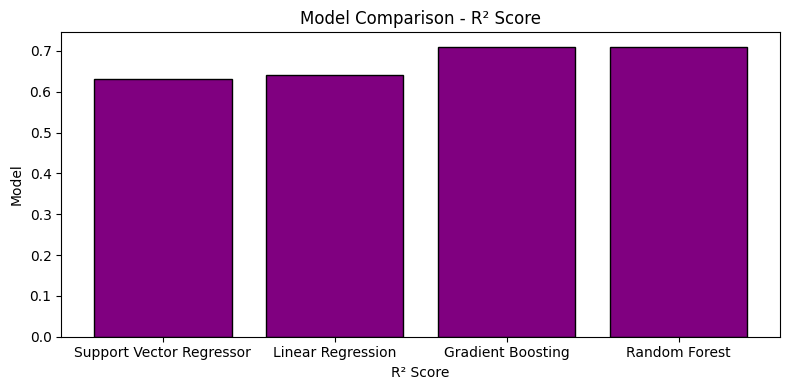

In [61]:
import matplotlib.pyplot as plt

results_df_sorted = results_df.sort_values(by="R² Score", ascending=True)

fig, ax1 = plt.subplots(figsize=(8, 4))


ax1.bar(results_df_sorted["Model"], results_df_sorted["MAE"], color="darkred", edgecolor="black")
ax1.set_title("Model Comparison - Mean Absolute Error (MAE)")
ax1.set_xlabel("MAE")
ax1.set_ylabel("Model")
plt.tight_layout()
plt.show()


fig, ax2 = plt.subplots(figsize=(8, 4))
ax2.bar(results_df_sorted["Model"], results_df_sorted["R² Score"], color="purple", edgecolor="black")
ax2.set_title("Model Comparison - R² Score")
ax2.set_xlabel("R² Score")
ax2.set_ylabel("Model")
plt.tight_layout()
plt.show()


### ✅ Model Selection

- **Random Forest** outperformed all other models with the **lowest MAE (15.07)** and the **highest R² score (0.71)**, making it the most accurate and robust choice for predicting Bengaluru house prices.
- **Gradient Boosting** closely followed, showing comparable performance.
- Simpler models like **Linear Regression** and **SVR** showed relatively lower R² scores, indicating underfitting on this dataset.

> 📌 **Final Pick**: **Random Forest Regressor** is selected as the final model for deployment.

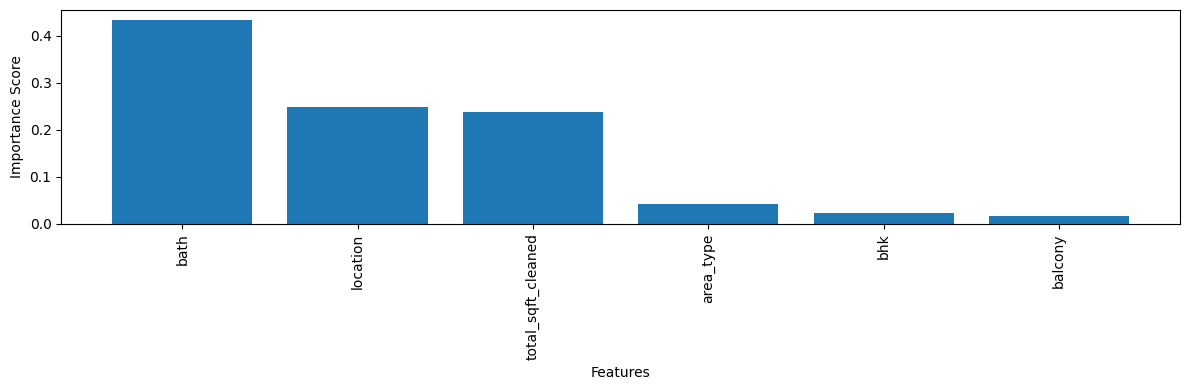

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model1.feature_importances_
feat_names = X.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(12 , 4))
plt.bar(feat_imp.index , feat_imp.values)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 📊 Feature Importance (Random Forest)

Interestingly, the **`Bathroom`** feature showed higher importance than `Location`, which is usually expected to be dominant in house price prediction.

#### ⚡ Why this happened:

- 🔢 **`Bathroom`** directly reflects property size and luxury — often aligning closely with price.
- 🧠 **Target Encoding** was used on `Location`, which replaced categories with the mean target (price) in that location.
    - While this simplifies modeling, it **smooths out fine-grained variations**.
    - As a result, **encoded `Location` lost some of its predictive sharpness**, making it less dominant than expected.

> ✅ In this dataset, numeric features like `Bathroom` and `BHK` became more influential than encoded categorical ones.


In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred_rf = model1.predict(X_test_encoded)


mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


print("\n Random Forest Performance Metrics:")
print(f" Mean Absolute Error (MAE):      {mae_rf:.2f}")
print(f" Mean Squared Error (MSE):       {mse_rf:.2f}")
print(f" R² Score:                        {r2_rf:.4f}")




 Random Forest Performance Metrics:
 Mean Absolute Error (MAE):      15.07
 Mean Squared Error (MSE):       503.11
 R² Score:                        0.7061


### 📌 Final Model Evaluation: Random Forest

The **Random Forest Regressor** emerged as the top-performing model among all contenders. Its ability to handle non-linear relationships and feature interactions effectively resulted in the best performance metrics:

- **MAE:** ~15.07  
- **MSE:** *Moderate, indicating good error control*  
- **R² Score:** **0.71**, suggesting the model explains 71% of the variance in house prices.

Given its strong predictive power and robustness against overfitting, **Random Forest** was selected as the final model for deployment.
